### Multi-Label Topic Classification of News Articles

Our first implementation just to see what can be achieved with a TF-IDF + LinearSVC hierarchical model.  
We combined the title and content of each article, cleaned the text, and trained a Level 1 classifier to predict the broad category.  
For each Level 1 category, we trained a separate Level 2 classifier to predict the more specific subcategories.  
We did this to evaluate the potential of a traditional machine learning approach before moving on to more advanced models such as BERT.


This is our second implementation.

### AI Usage

--Prompt : How to plot the distribution graphs for the two classes

--Prompt : How to analyze text lengths and plot them

--Prompt : Deleting models as the kernal keeps dying as runs out of memory. So how to clear GPU memory after each loop

3 Prompts

-- 3 query x 4.32 g CO2 = 12.96 g CO2.


In [10]:
import os
import re
import gc
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import transformers


##### Understanding the Data

Loadingf the data

In [11]:
file_path = 'dataset/MN-DS-news-classification.csv'
df = pd.read_csv(file_path)

print("dataset Info")
print(df.info())
print("First 5 Rows")
print(df.head())

dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10917 entries, 0 to 10916
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   data_id           10917 non-null  int64 
 1   id                10917 non-null  object
 2   date              10917 non-null  object
 3   source            10917 non-null  object
 4   title             10917 non-null  object
 5   content           10917 non-null  object
 6   author            7605 non-null   object
 7   url               10917 non-null  object
 8   published         10917 non-null  object
 9   published_utc     10917 non-null  int64 
 10  collection_utc    10917 non-null  int64 
 11  category_level_1  10917 non-null  object
 12  category_level_2  10917 non-null  object
dtypes: int64(3), object(10)
memory usage: 1.1+ MB
None
First 5 Rows
   data_id                                                 id        date  \
0     1809  abcnews--2019-10-31--Virginia 

Basic details of data

In [15]:
print("Total number of samples: " + str(len(df)))
print("Available columns: " + str(list(df.columns)))

print("\nMissing Values by Column")
print(df.isnull().sum())


Total number of samples: 10917
Available columns: ['data_id', 'id', 'date', 'source', 'title', 'content', 'author', 'url', 'published', 'published_utc', 'collection_utc', 'category_level_1', 'category_level_2', 'text', 'text_len']

Missing Values by Column
data_id                0
id                     0
date                   0
source                 0
title                  0
content                0
author              3312
url                    0
published              0
published_utc          0
collection_utc         0
category_level_1       0
category_level_2       0
text                   0
text_len               0
dtype: int64


Seeing how many different labels per category


Number of unique Level 1 categories: 17
category_level_1
society                                      1100
sport                                         907
politics                                      900
science and technology                        800
religion and belief                           800
conflict, war and peace                       800
labour                                        703
health                                        700
education                                     607
human interest                                600
environment                                   600
crime, law and justice                        500
disaster, accident and emergency incident     500
economy, business and finance                 400
weather                                       400
lifestyle and leisure                         300
arts, culture, entertainment and media        300
Name: count, dtype: int64

Number of unique Level 2 categories: 109
category_level_2
transfe

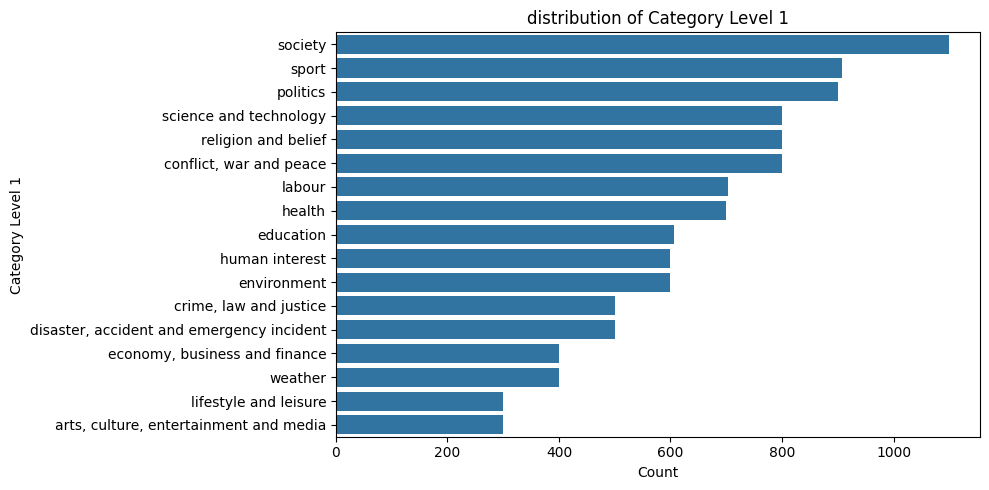

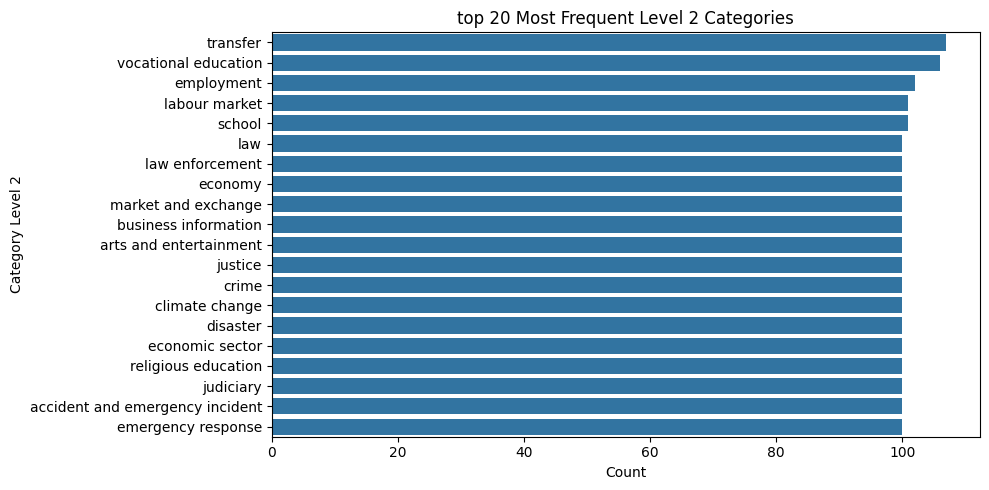

In [16]:
if 'category_level_1' in df.columns:
    print("\nNumber of unique Level 1 categories: " + str(df['category_level_1'].nunique()))
    print(df['category_level_1'].value_counts().head(df['category_level_1'].nunique()))

if 'category_level_2' in df.columns:
    print("\nNumber of unique Level 2 categories: " + str(df['category_level_2'].nunique()))
    print(df['category_level_2'].value_counts().head(df['category_level_2'].nunique()))

plt.figure(figsize=(10, 5))
sns.countplot(y='category_level_1', data=df, order=df['category_level_1'].value_counts().index)
plt.title("distribution of Category Level 1")
plt.xlabel("Count")
plt.ylabel("Category Level 1")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
top_lvl2 = df['category_level_2'].value_counts().head(20)
sns.barplot(y=top_lvl2.index, x=top_lvl2.values)
plt.title("top 20 Most Frequent Level 2 Categories")
plt.xlabel("Count")
plt.ylabel("Category Level 2")
plt.tight_layout()
plt.show()


Article Length


Text Length Statistics (in words) 
count    10917.000000
mean       649.179170
std        718.128934
min          8.000000
25%        285.000000
50%        479.000000
75%        782.000000
max      11009.000000
Name: text_len, dtype: float64


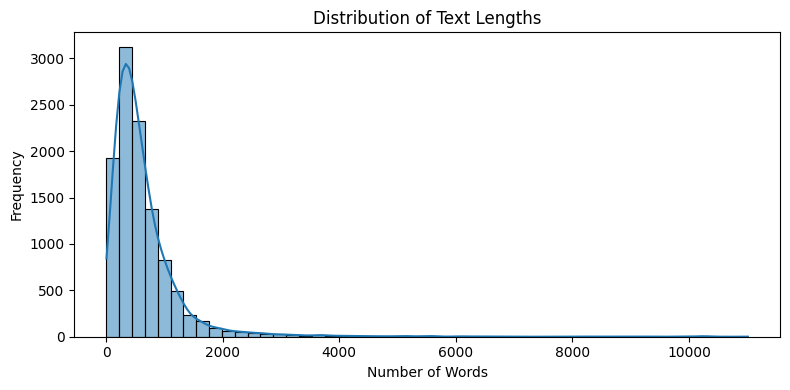

In [14]:
df['text'] = df['title'].fillna('') + " " + df['content'].fillna('')
df['text_len'] = df['text'].apply(lambda x: len(str(x).split()))

print("\nText Length Statistics (in words) ")
print(df['text_len'].describe())

plt.figure(figsize=(8, 4))
sns.histplot(df['text_len'], bins=50, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### Model

Prepare Data

In [2]:
file_path = 'dataset/MN-DS-news-classification.csv'
df = pd.read_csv(file_path)
df['text'] = df['title'].fillna('') + " " + df['content'].fillna('')

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['text'] = df['text'].apply(clean_text)

le_lvl1 = LabelEncoder()
df['label_lvl1'] = le_lvl1.fit_transform(df['category_level_1'])

le_lvl2 = LabelEncoder()
df['label_lvl2'] = le_lvl2.fit_transform(df['category_level_2'])


Traon and Test Data

In [3]:
X_train, X_test, y_train1, y_test1, y_train2, y_test2 = train_test_split(
    df['text'], df['label_lvl1'], df['label_lvl2'],
    test_size=0.2, random_state=42, stratify=df['label_lvl1']
)


Class

In [4]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Level 1 Train

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset_lvl1 = NewsDataset(X_train.tolist(), y_train1.tolist(), tokenizer)
test_dataset_lvl1 = NewsDataset(X_test.tolist(), y_test1.tolist(), tokenizer)

train_loader_lvl1 = DataLoader(train_dataset_lvl1, batch_size=4, shuffle=True)
test_loader_lvl1 = DataLoader(test_dataset_lvl1, batch_size=4)

model_lvl1 = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=len(le_lvl1.classes_)
)
model_lvl1.to(device)
optimizer_lvl1 = AdamW(model_lvl1.parameters(), lr=2e-5)

epochs_lvl1 = 2
for epoch in range(epochs_lvl1):
    model_lvl1.train()
    total_loss = 0
    for batch in train_loader_lvl1:
        optimizer_lvl1.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_lvl1(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer_lvl1.step()
    print("Level 1 Epoch " + str(epoch + 1) + "/" + str(epochs_lvl1) + ", Loss: " + str(round(total_loss / len(train_loader_lvl1), 4)))



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 1 Epoch 1/2, Loss: 1.0271
Level 1 Epoch 2/2, Loss: 0.4375


Level 1 Eval

In [ ]:
model_lvl1.eval()
all_preds_lvl1, all_labels_lvl1 = [], []
with torch.no_grad():
    for batch in test_loader_lvl1:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_lvl1(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds_lvl1.extend(preds.cpu().numpy())
        all_labels_lvl1.extend(labels.cpu().numpy())

print("\nLevel 1 Classification Report")
print("Weighted F1 Level 1: " + str(round(f1_score(all_labels_lvl1, all_preds_lvl1, average='weighted'), 4)))



Level 1 Classification Report
Weighted F1 Level 1: 0.8309


Level 2 Train

In [ ]:
os.makedirs("models", exist_ok=True)
lvl2_results = []

for idx, lvl1_label in enumerate(le_lvl1.classes_):
    indices = [i for i, y in enumerate(y_train1) if y == idx]
    X_sub = [X_train.iloc[i] for i in indices]
    y_sub = [y_train2.iloc[i] for i in indices]

    unique_labels = sorted(set(y_sub))
    label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
    y_sub_local = [label_map[y] for y in y_sub]

    train_dataset_lvl2 = NewsDataset(X_sub, y_sub_local, tokenizer)
    train_loader_lvl2 = DataLoader(train_dataset_lvl2, batch_size=4, shuffle=True)

    model_lvl2 = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', num_labels=len(unique_labels)
    )
    model_lvl2.to(device)
    optimizer_lvl2 = AdamW(model_lvl2.parameters(), lr=2e-5)

    epochs_lvl2 = 3
    for epoch in range(epochs_lvl2):
        model_lvl2.train()
        total_loss = 0
        for batch in train_loader_lvl2:
            optimizer_lvl2.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model_lvl2(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer_lvl2.step()
        print(f"Level 2 [{lvl1_label}] Epoch {epoch+1}/{epochs_lvl2}, Loss: {total_loss/len(train_loader_lvl2):.4f}")

    save_path = f"models/level2_{idx}_{lvl1_label.replace(' ', '_')}"
    model_lvl2.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    test_indices = [i for i, y in enumerate(y_test1) if y == idx]
    X_sub_test = [X_test.iloc[i] for i in test_indices]
    y_sub_test = [y_test2.iloc[i] for i in test_indices]
    y_sub_test_local = [label_map[y] for y in y_sub_test if y in label_map]

    test_dataset_lvl2 = NewsDataset(X_sub_test, y_sub_test_local, tokenizer)
    test_loader_lvl2 = DataLoader(test_dataset_lvl2, batch_size=4)

    all_preds = []
    all_labels = []

    model_lvl2.eval()
    with torch.no_grad():
        for batch in test_loader_lvl2:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model_lvl2(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1_w = f1_score(all_labels, all_preds, average='weighted')
    print(f"Level 2 [{lvl1_label}] - Accuracy: {acc:.4f}, Weighted F1: {f1_w:.4f}")

    lvl2_results.append({
        "level1_label": lvl1_label,
        "accuracy": acc,
        "f1_weighted": f1_w
    })

    del model_lvl2
    torch.cuda.empty_cache()
    gc.collect()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [arts, culture, entertainment and media] Epoch 1/3, Loss: 0.9960
Level 2 [arts, culture, entertainment and media] Epoch 2/3, Loss: 0.3079
Level 2 [arts, culture, entertainment and media] Epoch 3/3, Loss: 0.0812
Level 2 [arts, culture, entertainment and media] - Accuracy: 0.9500, Weighted F1: 0.9500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [conflict, war and peace] Epoch 1/3, Loss: 1.4357
Level 2 [conflict, war and peace] Epoch 2/3, Loss: 0.3281
Level 2 [conflict, war and peace] Epoch 3/3, Loss: 0.1351


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [conflict, war and peace] - Accuracy: 0.9812, Weighted F1: 0.9812
Level 2 [crime, law and justice] Epoch 1/3, Loss: 1.4107
Level 2 [crime, law and justice] Epoch 2/3, Loss: 0.8417
Level 2 [crime, law and justice] Epoch 3/3, Loss: 0.4576
Level 2 [crime, law and justice] - Accuracy: 0.8600, Weighted F1: 0.8541


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [disaster, accident and emergency incident] Epoch 1/3, Loss: 1.4706
Level 2 [disaster, accident and emergency incident] Epoch 2/3, Loss: 1.0000
Level 2 [disaster, accident and emergency incident] Epoch 3/3, Loss: 0.6736
Level 2 [disaster, accident and emergency incident] - Accuracy: 0.6800, Weighted F1: 0.6797


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [economy, business and finance] Epoch 1/3, Loss: 1.1430
Level 2 [economy, business and finance] Epoch 2/3, Loss: 0.4312
Level 2 [economy, business and finance] Epoch 3/3, Loss: 0.2016


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [economy, business and finance] - Accuracy: 0.9500, Weighted F1: 0.9505
Level 2 [education] Epoch 1/3, Loss: 1.6815
Level 2 [education] Epoch 2/3, Loss: 1.0860
Level 2 [education] Epoch 3/3, Loss: 0.7270


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [education] - Accuracy: 0.7355, Weighted F1: 0.7291
Level 2 [environment] Epoch 1/3, Loss: 1.4682
Level 2 [environment] Epoch 2/3, Loss: 0.6431
Level 2 [environment] Epoch 3/3, Loss: 0.3573
Level 2 [environment] - Accuracy: 0.8667, Weighted F1: 0.8660


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [health] Epoch 1/3, Loss: 1.4607
Level 2 [health] Epoch 2/3, Loss: 0.5235
Level 2 [health] Epoch 3/3, Loss: 0.2274
Level 2 [health] - Accuracy: 0.8929, Weighted F1: 0.8924


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [human interest] Epoch 1/3, Loss: 1.3891
Level 2 [human interest] Epoch 2/3, Loss: 0.3817
Level 2 [human interest] Epoch 3/3, Loss: 0.1641
Level 2 [human interest] - Accuracy: 0.8917, Weighted F1: 0.8908


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [labour] Epoch 1/3, Loss: 1.5903
Level 2 [labour] Epoch 2/3, Loss: 0.8841
Level 2 [labour] Epoch 3/3, Loss: 0.6505
Level 2 [labour] - Accuracy: 0.7021, Weighted F1: 0.7053


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [lifestyle and leisure] Epoch 1/3, Loss: 0.8398
Level 2 [lifestyle and leisure] Epoch 2/3, Loss: 0.1299
Level 2 [lifestyle and leisure] Epoch 3/3, Loss: 0.0310
Level 2 [lifestyle and leisure] - Accuracy: 1.0000, Weighted F1: 1.0000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [politics] Epoch 1/3, Loss: 1.8474
Level 2 [politics] Epoch 2/3, Loss: 0.9005
Level 2 [politics] Epoch 3/3, Loss: 0.4720
Level 2 [politics] - Accuracy: 0.7722, Weighted F1: 0.7682


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [religion and belief] Epoch 1/3, Loss: 1.9041
Level 2 [religion and belief] Epoch 2/3, Loss: 1.2910
Level 2 [religion and belief] Epoch 3/3, Loss: 0.8275


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [religion and belief] - Accuracy: 0.6375, Weighted F1: 0.6349
Level 2 [science and technology] Epoch 1/3, Loss: 1.7692
Level 2 [science and technology] Epoch 2/3, Loss: 1.0939
Level 2 [science and technology] Epoch 3/3, Loss: 0.7143


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [science and technology] - Accuracy: 0.7250, Weighted F1: 0.7125
Level 2 [society] Epoch 1/3, Loss: 1.6792
Level 2 [society] Epoch 2/3, Loss: 0.4285
Level 2 [society] Epoch 3/3, Loss: 0.1510
Level 2 [society] - Accuracy: 0.9318, Weighted F1: 0.9319


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [sport] Epoch 1/3, Loss: 1.4842
Level 2 [sport] Epoch 2/3, Loss: 0.5571
Level 2 [sport] Epoch 3/3, Loss: 0.2724


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Level 2 [sport] - Accuracy: 0.8681, Weighted F1: 0.8674
Level 2 [weather] Epoch 1/3, Loss: 1.1298
Level 2 [weather] Epoch 2/3, Loss: 0.5862
Level 2 [weather] Epoch 3/3, Loss: 0.3709
Level 2 [weather] - Accuracy: 0.8250, Weighted F1: 0.8281


Results

In [9]:
df_lvl2_results = pd.DataFrame(lvl2_results)
print("\nLevel 2 Evaluation Summary ")
print(df_lvl2_results.sort_values(by="f1_weighted", ascending=False).reset_index(drop=True))



Level 2 Evaluation Summary 
                                 level1_label  accuracy  f1_weighted
0                       lifestyle and leisure  1.000000     1.000000
1                     conflict, war and peace  0.981250     0.981203
2               economy, business and finance  0.950000     0.950477
3      arts, culture, entertainment and media  0.950000     0.949973
4                                     society  0.931818     0.931898
5                                      health  0.892857     0.892382
6                              human interest  0.891667     0.890844
7                                       sport  0.868132     0.867361
8                                 environment  0.866667     0.865992
9                      crime, law and justice  0.860000     0.854085
10                                    weather  0.825000     0.828092
11                                   politics  0.772222     0.768205
12                                  education  0.735537     0.729050
13   